## Image similarity tool 

In [ ]:
# install ml dependencies
! pip install --upgrade pip
! pip install tensorflow 
! pip install tensorflow_hub
! pip install opencv-python
! pip install tensorflow_estimator==2.6.0  # forcing to install specific version

# download a python file with helper methods for image similarity
# ! curl -L https://analytics.wikimedia.org/published/datasets/one-off/image_similarity/image_similarity_tools.py -o image_similarity_tools.py
'''We have a modified version of image_similarity_tools'''

# download data    
! curl -L https://analytics.wikimedia.org/published/datasets/one-off/image_similarity/microtask_data.tar.gz -o microtask_data.tar.gz
! tar -xf microtask_data.tar.gz
! rm microtask_data.tar.gz

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import cv2
import random
import pickle
import os
import numpy as np
from scipy import spatial
import time
import math

from image_similarity_tools import run_me, plot


2021-11-06 15:25:05.792373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /srv/paws/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-06 15:25:05.792432: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-06 15:25:08.455301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /srv/paws/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-06 15:25:08.455351: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-06 15:25:08.455382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to b

get_features.py contains functions from [Wikimania19](https://github.com/mirrys/Wikimania_19_Tutorial/) to extract color and object features, as well as a function to measure cosine distances

image_feature_tensorflow.py is taken as is from that repo, after using tf_upgrade_v2 to upgrade TF1 code to TF2

## Data

There are pictures of three categories: dog, fox and wolf. The image file name is the name of the file on wikiedia commons. We can iterate over the image files in their respective category folders in the `data` directory.

In [2]:
for root, dirs, files in os.walk("data"):
    if len(files)>0:
        print(f'category {os.path.basename(root)} contains {len(files)} images')
        print(f'\texample images: {files[:2]}')

category Wolf contains 290 images
	example images: ['Loups_siberie.jpg', 'Canis_lupus_signatus_(Kerkrade_Zoo)_26.jpg']
category Fox contains 143 images
	example images: ['Kew_Gardens_-_London_-_September_2008_(2958753889).jpg', 'Vulpes_vulpes_qtl1.jpg']
category Dog contains 283 images
	example images: ['Henry_Tenré.jpg', '(2)_Isha_female_rajapalayam.jpg']


In [3]:
run_me()

Let's start with an initial analsys of the images in the dataset. This can be done by iterating over the files and using dict to accumulate results, but feel free to install to other libraries.

- number of images; total, per category
- resolution of images; avergage, are there outliers that might cause problems?
- file size; total, average, per category

-------------------------

### Number of images

In [4]:
total = 0
for root, dirs, files in os.walk("data"):
    if len(files)>0:
        print(f'Category {os.path.basename(root)} contains {len(files)} images')
        
        total += len(files)
        
print(f'\nTotal: {total} images')

Category Wolf contains 290 images
Category Fox contains 143 images
Category Dog contains 283 images

Total: 716 images


### Resolution of images

In [5]:
data = 'data'

resolutions = {}
for category in os.listdir(data):
    resolutions[category] = {}
    i=0
    for file in os.listdir(os.path.join(data,category)):
        filepath = os.path.join(data, category, file)
        # Filepaths as keys and numpy arrays of their dimensions as values
        try:
            resolutions[category][filepath] = cv2.imread(filepath).shape
        except:
            # cv2.imread fails for cache files and files with special characters
            # we rename these to some generic 'Dog(i).jpg'
            if file.endswith('.jpg'):
                while True:
                    try:
                        newpath = os.path.join(data, category, category + str(i) + '.jpg')
                        os.rename(filepath, newpath)
                        
                        resolutions[category][newpath] = cv2.imread(newpath).shape
                        break
                    except:
                        # if Dog6.jpg is taken try Dog7.jpg
                        i+=1
            pass

In [6]:
def res_averages(res):
    for category in res:
        avg = np.mean(list(res[category].values()), axis = 0)
        print(f'{category} average resolution is {avg[0] :.3f} by {avg[1] :.3f}')
    
    glob_res = [res[x][y] for x in res for y in res[x]]
    glob_avg = np.mean(glob_res, axis = 0)
    print(f'\nGlobal average resolution is {glob_avg[0] :.3f} by {glob_avg[1] :.3f}')
    
res_averages(resolutions)

Wolf average resolution is 438.727 by 599.986
Fox average resolution is 713.901 by 599.993
Dog average resolution is 473.780 by 599.993

Global average resolution is 507.394 by 599.990


Exploring the ran image_similarity_tools.run_me(), we noticed an added image consisting of 100 (vertical) copies of a data point. However, we want a robust way to identify outliers generally. There are multiple methods for anomaly detection, we will first deploy a visual representation of our data to better grasp it. 

We will rearrage our data to plot 6 initial sets: height and width for each wolf, dog and fox.

In [7]:
# Create our dictionary with heights and widths
def plottable_data(resolutions):
    dims = {}
    for category in resolutions:
        dims[category] = {}
        dims[category]['heights'] = [resolutions[category][filename][0] for filename in resolutions[category]]
        dims[category]['widths'] = [resolutions[category][filename][1] for filename in resolutions[category]]
    return dims
    
dims = plottable_data(resolutions)

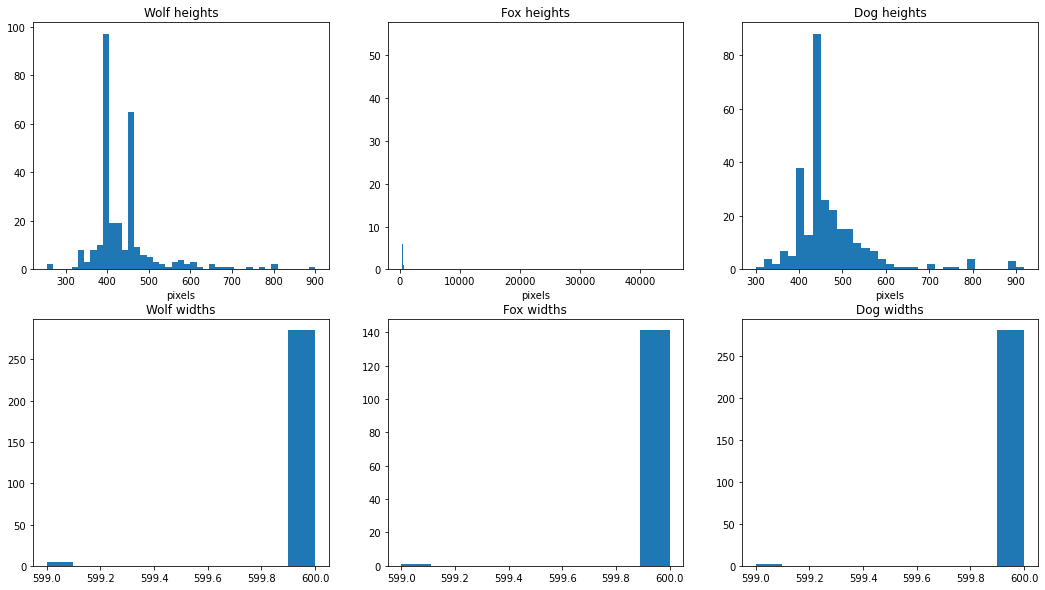

In [8]:
def wh_plotter(data, log = False, x = False):
    f, axes = plt.subplots(2,len(data))
    i = 0
    for category in data:
        axes[0][i].hist(data[category]['heights'], bins = 'auto', log = log)
        axes[0][i].set_title(category + ' heights')
        axes[0][i].set_xlabel('pixels')

        axes[1][i].hist(data[category]['widths'], bins = 'auto')
        axes[1][i].set_title(category + ' widths')

        i+=1
            
    f.set_size_inches(18, 10)
            
wh_plotter(dims)         
        

Clearly the x100 copied image is making it hard to visualize Fox heights. Even if we didn't knew about it in the first place, we can infer from the graph limits there is some data with height over 40000.

As for widths, we can see for each category exists a small amount of pictures whose width is 599 instead of 600. Although we could take these as 'outliers', it remains to be seen if this discrepancy will affect our sorting algorithms. Anyhow, we id them.

In [9]:
outliers = []
for category in resolutions:
    for filepath in resolutions[category]:
        img = cv2.imread(filepath)
        if img.shape[1] != 600 or img.shape[0] > 40000:
            outliers.append(filepath)

Now that we have the eggregious offenders we can update our data, take another look and see how we're going to proceed on possibly less obvious outliers.

In [10]:
# Delete from resolutions dictionary the outliers, we may want to keep a history
def remove_outliers(res, outliers, hist = False, label = ''):
    # Save deleted files with label of the change
    if type(hist) == dict:
        hist[label] = []
        
    for outlier in outliers:
        try:
            del res[outlier.split('/')[1]][outlier]
            print('Deleted ' + outlier)
            hist[label].append(outlier)
        except:  
            pass
        

In [11]:
delete_hist = {}
remove_outliers(resolutions, outliers, delete_hist, 'outliers1')

Deleted data/Wolf/A_gray_wolf_fitted_with_a_radio_collar_is_released_into_the_wild.jpg
Deleted data/Wolf/Korean_wolves_mating_(cropped).jpg
Deleted data/Wolf/Indian_Wolf_Photo_Dhaval_Vargiya.jpg
Deleted data/Wolf/GIPE25_-_Un_Loup_(by)_(3).jpg
Deleted data/Fox/Fox_-_British_Wildlife_Centre_(17429406401).jpg
Deleted data/Fox/foxes.jpg
Deleted data/Dog/Irish_wolfhound_giaccomo.jpg
Deleted data/Dog/Barry_dog.jpg


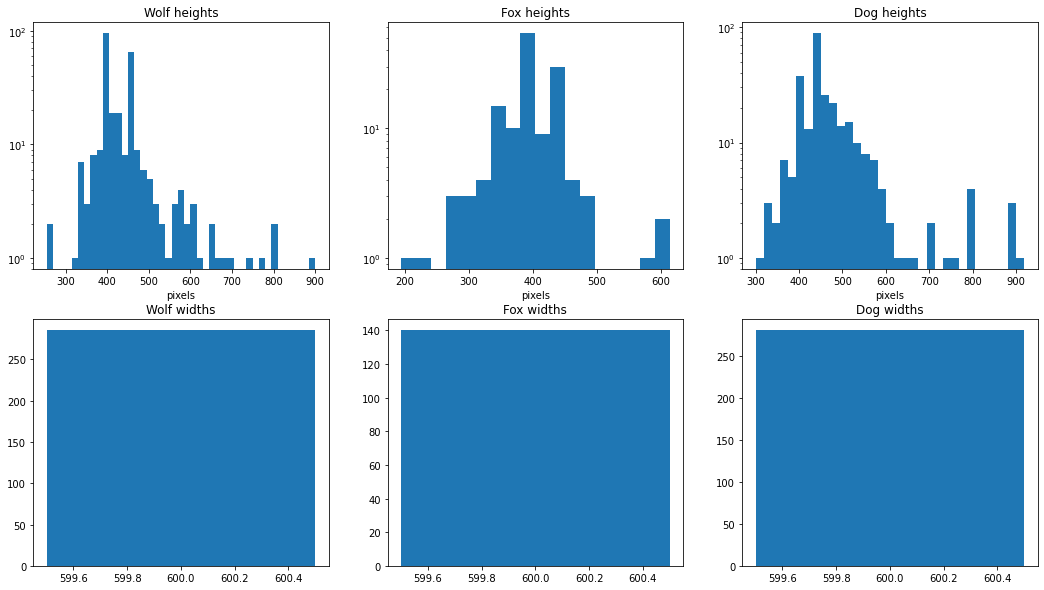

In [12]:
# Recalculate the dimension lists for plotting
new_dims = plottable_data(resolutions)

wh_plotter(new_dims, log = True)

### Possible further filtering of outliers

We could use the interquartile method (aka Tukey's fences).

From [Wikipedia](https://en.wikipedia.org/wiki/Outlier#Tukey's_fences):

>Other methods flag observations based on measures such as the interquartile range. For example, if $Q_1$ and $Q_3$ are the lower and upper quartiles respectively, then one could define an outlier to be any observation outside the range:
>
>$$ [Q_1 - k(Q_3 - Q_1), Q_3 + k(Q_3 - Q_1)] $$
>
>for some nonnegative constant $k$. John Tukey proposed this test, where $k=1.5$ indicates an "outlier", and $k=3$ indicates data that is "far out".

This could use some exploration, esp. in regards to the type of distribution of our data and the best method for it.

With this updated set of data, we can calculate the averages again.

In [13]:
res_averages(resolutions)

Wolf average resolution is 439.547 by 600.000
Fox average resolution is 399.814 by 600.000
Dog average resolution is 474.214 by 600.000

Global average resolution is 445.426 by 600.000


### File sizes

In [14]:
def avg(lst):
    return sum(lst) / len(lst)

# List of sizes by category
sizes={}
for category in resolutions:
    sizes[category] = [os.path.getsize(filepath) for filepath in resolutions[category]]

In [15]:
for category in sizes:
    print(f'{category} average size: {avg(sizes[category]) / 1024 : .3f} kB')

glob_avg = avg(sizes['Wolf'] + sizes['Fox'] + sizes['Dog'])
print(f'\nGlobal average size: {glob_avg / 1024 : .3f} kB')

Wolf average size:  92.296 kB
Fox average size:  89.355 kB
Dog average size:  87.539 kB

Global average size:  89.823 kB


In [16]:
for category in sizes:
    print(f'{category} size: {sum(sizes[category]) / 1024**2 : .3f} MB')

glob_sum = sum(sizes['Wolf'] + sizes['Fox'] + sizes['Dog'])
print(f'\nTotal size: {glob_sum / 1024**2 : .3f} MB')

Wolf size:  25.688 MB
Fox size:  12.217 MB
Dog size:  23.936 MB

Total size:  61.841 MB


#### End of the first microtask

## Image similarity API

In this section we will implement an "API", which is just a python function in fact, 
that takes an input image, and returns a set of similar images from the dataset.

The `algorithm` argument specifies which approach should be used to generate the image recommendations:
- "metadata-based": hacky example algorithm that uses the fact that the file path contains the category
- "random": returns random images 
- "deeplearning": algorithm that uses the label predictions from the `run_inference_on_image` method to generate similar images
- "color_distribution": algorithm that uses the distribution of colors in images to recommend similar images

One direct approach is to first extract features from an image, and then use a distance metric (e.g. euclidian) to compute the nearest neighbors. 

This microtask is based on a Wikimania [workshop](https://github.com/mirrys/Wikimania_19_Tutorial/) on image similarity, the notebooks contain useful code to extract features from an image.



--------------------------------

In [17]:
from get_features import extract_color_distribution, compare_images

#### *compare_images* from the [workshop](https://github.com/mirrys/Wikimania_19_Tutorial/) utilizes the cosine distance between the vectors of features

This is interesting, the euclidian distance or 2-norm is a measure of 'absolute' geometrical distance between two vectors, whereas the cosine distance measures the discrepancy  between two vectors' directions (the *angle*).

$$ CD = 1 - \frac{u \cdot v}{|u||v|} $$

For this use case, the proportion between the features' values is what determines the 'fingerprint' of an image, e.g. how much is the image related to X compared to Y. We want two images to have maximum similarity when the proportions of their features are the same, even if at a different scale, or distance 0 in this case. 2-norm and cosine distance are only univocally related when the vectors are normalized, so we will use the cosine metric for robustness. In fact, the features obtained with Wm19 code are probabilities, which aren't 2-normalized.

#### *extract_color_distribution* is another function from Wikimania 19, it works in two parts

First, we must understand that cv2 library for reading images gets the information of an image as a 'matrix with depth'. The height and width of the matrix are exactly the resolution of the image. The depth is 3 (we saw this when manipulating our resolutions dictionary), so each pixel is described by its 3 RGB values. 

But this is one model of color representation, another model is HSV or hue, saturation, and value. We can think of this as giving the coordinates of a point in 3D either in cartesian or cylindrical coordinates. They are different representations of the same thing, and incidentally, HSV model is commonly depicted as a half-cylinder.

This conversion is convenient for one reason mainly. In this model of color, the value of hue is the angle of the half-cylinder. This allows us to neatly divide the possible values of hue, each of $\frac{180°}{12} = 15°$. Saturation and value in this model can be understood as 'how washed in white or black' is the color, respectively. So the information of our common concept of color is carried by the hue, with the other two being measures of intensity.

And that's extract_color_distribution. After the RGB -> HSV conversion, we know the hue for each pixel, so we can know in which of the 12 sections or colors it falls. And the function returns that distribution.

In [18]:
from image_similarity_tools import classify_image

#### *classify_image*  preprocesses, then predicts

First it reads the image with cv2, and then resizes it to a preset shape of 224 by 224. This immediately tells me that, as suspected from the variance in heights in our data and the good performance that we'll see in the following cells regardless, the 599px wide outliers are most likely perfectly workable. Then each of the 3 entries per pixel is divided by 255, this isn't a surprise as we know the pixels are represented in RGB and most models work with values between 0 and 1.

It then uses Keras' linear grouping of neural network layers `keras.Sequential`. Our model is mobilenet_v2, specifically the checkpoint `mobilenet_v2_1.0_224` pretrained on the dataset from ImageNet Large Scale Visual Recognition Challenge 2012. The same one that the Inception model used in Wikimania 19 was trained on. Setting the input and output sizes, and knowing beforehand the names of the labels that the ordered outputs [correspond to](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt), uses Keras' `predict()` method to get the predictions on our inputs and finally interprets them as a probability distribution via softmax.

In [19]:
# We create a list with the all the image file paths
onlyfiles = [x for cat in resolutions for x in resolutions[cat]]

# Now we are going to need a couple dictionaries, each with file paths as keys
# Raw images has the cv2.imread image info
# color and obj features have the features fetched with the extract_color_distribution and extract_object
# functions from Wikimania19
raw_images={}
color_features={}
obj_features={}

color_time = time.time()
for file in onlyfiles:
    # Create the color features database. extract_color_distribution neatly returns a dictionary
    raw_images[file] = cv2.imread(file)
    color_features[file] = extract_color_distribution(raw_images[file])
print(f'Time for color features: {time.time() - color_time : .3f} s')

obj_time = time.time()
for file in onlyfiles:
    # Now we use classify_mage to extract object features
    obj_features[file] = dict(classify_image(file))
print(f'Time for object features: {time.time() - obj_time : .3f} s')

Time for color features:  6.702 s
Time for object features:  247.280 s


In [20]:
# Returns similarities dict between the input and every other image
def obj_similarities(filename):
    sims = {}
    for file in onlyfiles:
        sims[file] = compare_images(obj_features[filename],obj_features[file])
    return(sims)

def color_similarities(filename):
    sims = {}
    for file in onlyfiles:
        sims[file] = compare_images(color_features[filename],color_features[file])
    return(sims)

In [21]:
def get_similar_images(input_image, algorithm, n_recommendation=5):
    """
    Given an input image, this method returns a list of similar images.    
    
    :param input_image: file name of an image
    :param algorithm: algorithm to use for recommendations
    :return: list of image recommendations
    """
    if algorithm=="metadata-based":
        category = input_image.rsplit('/')[1]
        category_files = list(resolutions[category].keys())
        recommendations = random.sample(category_files, n_recommendation)
        return recommendations
    
    elif algorithm == "random": 
        recommendations = random.sample(onlyfiles, n_recommendation) 
        return recommendations
    
    # For these 2 we'll use the sims functions, which are dictionaries of similarities between
    # the input and all the data (including itself) via color or object prediction
    # We just need to sort the similarities and return the top n_recommendation images
    elif algorithm == "deeplearning": 
        sims = obj_similarities(input_image)
        return list(sorted(sims, key = sims.get))[:n_recommendation] 
        
    elif algorithm == "color_distribution": 
        sims = color_similarities(input_image)
        return list(sorted(sims, key = sims.get))[:n_recommendation]  
                      
    else:
        raise ValueError(f'algorithm {algorithm} not implemented')

### Example queries

In [22]:
get_similar_images(
    input_image='data/Wolf/Timberwolf_Juli_2009_Zoo_Hannover.jpg',
    algorithm="metadata-based")    

['data/Wolf/WallaWalla_160116_(25770616481).jpg',
 'data/Wolf/Canis_lupus_Parc_Alpha_003.jpg',
 'data/Wolf/GrayWolves.jpg',
 'data/Wolf/Волк_2.jpg',
 'data/Wolf/Em_-_Canis_lupus_pallipes_-_India_1.jpg']

In [23]:
get_similar_images(
    input_image='data/Wolf/Timberwolf_Juli_2009_Zoo_Hannover.jpg',
    algorithm="random")

['data/Wolf/Tibetan_Wolf_By_Stanzin_(Stakpa)_cropped.jpg',
 'data/Dog/Golden_Retriever_2009.jpg',
 'data/Dog/American_Brittany_standing.jpg',
 'data/Fox/Rebane_nägi_Rebast.jpg',
 'data/Wolf/Weißer_Wolf_(5543289311).jpg']

In [24]:
test_color = get_similar_images(
    input_image='data/Wolf/Timberwolf_Juli_2009_Zoo_Hannover.jpg',
    algorithm="color_distribution",
    n_recommendation = 8)
test_color

['data/Wolf/Timberwolf_Juli_2009_Zoo_Hannover.jpg',
 'data/Wolf/Canis_lupus_signatus_(Kerkrade_Zoo)_32.jpg',
 'data/Wolf/Wolf_Canis_lupus_Wildpark_Poing-06.jpg',
 'data/Dog/Schläfriger_Hund_Fulda_Juni_2012.jpg',
 'data/Dog/AHeraclea39.jpg',
 "data/Fox/Volpe_al_parco_dell'uccellina_Maremma.jpg",
 'data/Wolf/Running_Wolf_2_(5696466615).jpg',
 'data/Fox/PRESPES6.jpg']

In [25]:
test_obj = get_similar_images(
    input_image='data/Wolf/Timberwolf_Juli_2009_Zoo_Hannover.jpg',
    algorithm="deeplearning", 
    n_recommendation = 6)
test_obj

['data/Wolf/Timberwolf_Juli_2009_Zoo_Hannover.jpg',
 'data/Wolf/2018-04-04_Wildpark_Güstrow_23.jpg',
 'data/Wolf/Eekhol193t_5.9.10_297_bearbeitet-1.jpg',
 'data/Wolf/Canis_lupus_qtl2_(bearbeitet).jpg',
 'data/Wolf/Wolf_Tierpark_Hellabrunn-2.jpg',
 'data/Wolf/Eurasian_Wolf.jpg']

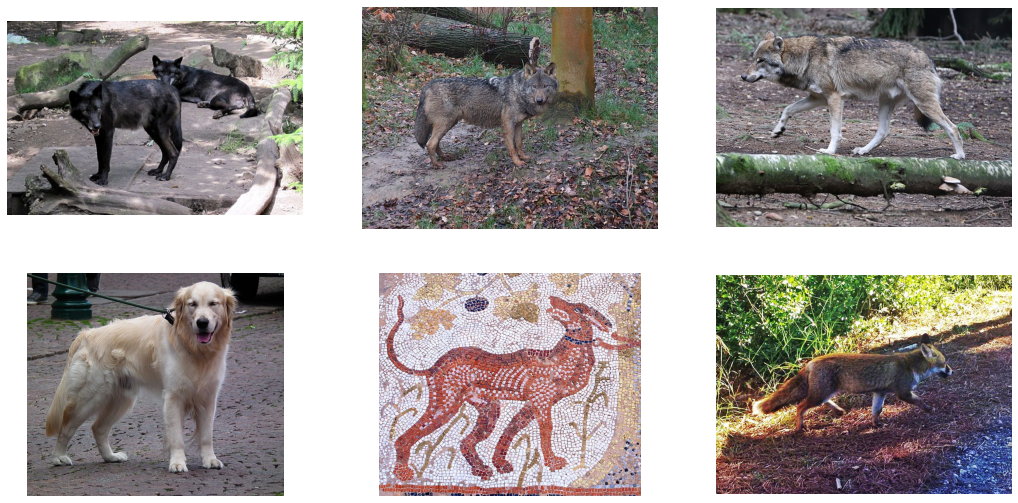

In [26]:
plot(test_color,(2,3))

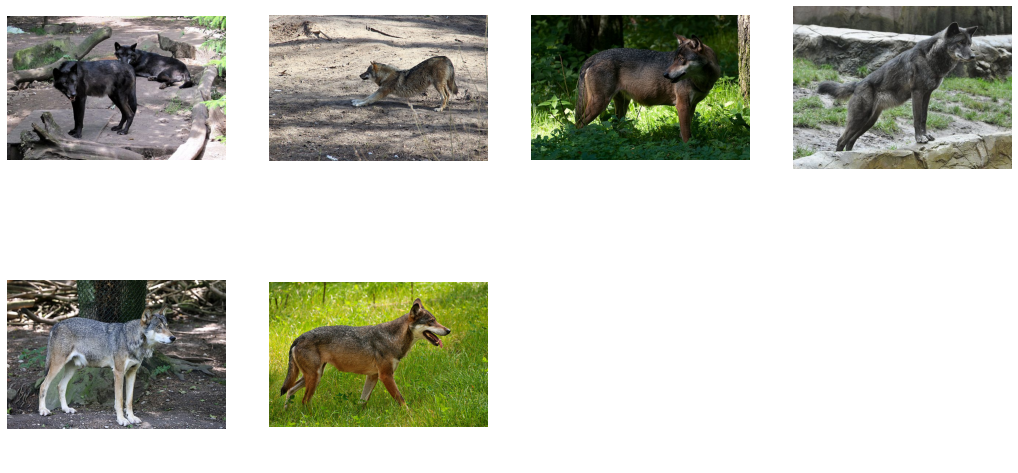

In [27]:
plot(test_obj,(2,4))

#### End of the second microtask

## Analysis

Let's generate a summary of how the different models perform. 
- For each algorithm, calculate how often the recommended images are in the same overall category (Dog/Fox/Wolf) as the input image? Can we compute a precision/recall? 
- How do the precision/recall results compare to the "random" baseline algorithm?

-----------------------------------

The script that we wrote returns as recommendations the closest $N$ images to an input via the features. 

Let's say the input is in Wolf, and there are $W = 205$ images in Wolf. Out of the $N$ recommendations, $M$ ($M \leq N$) are also in Wolf. Precision is then given by $P = \frac{M}{N}$; ideally for low N (the very closest neighbours) precision stays at around 1. 

Recall on the other hand is $R = \frac{M}{W}$, but $M = M(N)$, so recall will depend greatly on the amount of neighbours returned.

Our variables end up being:
1. What images we're going to feed as input
2. Hoy many recommendations we're retrieving.

First we'll take a sample of 10 images to do the tests for each category. Since metadata-based returns a random sample in the same category 

In [28]:
sample_wolf = get_similar_images(
    input_image='data/Wolf/Timberwolf_Juli_2009_Zoo_Hannover.jpg',
    algorithm="metadata-based",
    n_recommendation = 10)

sample_fox = get_similar_images(
    input_image='data/Fox/Young_vulpes_vulpes_near_N98_Finnmark_Norway-2012-07-09-16-55-031.jpg',
    algorithm="metadata-based",
    n_recommendation = 10)

sample_dog = get_similar_images(
    input_image='data/Dog/German_shepherd.jpg',
    algorithm="metadata-based",
    n_recommendation = 10)

We can define 3 number of recommendations:
1. n such that the lowest scoring recommendation has at most a distance score of $ 1 - \frac{1}{\sqrt(2)}$. This corresponds to halfway through to orthogonality.
2. n such that the lowest scoring recommendation has at most a distance score of $ 1 - \frac{1}{2}$. This corresponds to a projection over the input losing half its magnitude ('you can represent half this image's feature vector with the input's feature vector').
3. n equal to the total amount of images in that category. This corresponds to the maximum value where precision can still be 1 and the minimum value where recall could theoretically be 1. Here precision = recall. If anything, could be the most interesting one.

Let's take a look at the average precision/recall for a random sample of each data category, taking the 3rd number of recommendations, and compare it across the different algorithms. 

In [29]:
# Calculate precision and recall, simply
def get_pr(image, algorithm, n):
    category = image.split('/')[1]
    pr = {}
    
    results = get_similar_images(image, algorithm, n)
    
    true_positives = len([r for r in results if r.split('/')[1] == category])
    
    pr['precision'] = true_positives / len(results)
    pr['recall'] = true_positives / len(resolutions[category])
    
    return pr

In [30]:
# A function that gets the 3 defined n's for each image
# It only makes sense to get the first two for the color and object similarity algorithms, third is the same for all
def get_ns(image, algorithm):
    category = image.split('/')[1]
    ns = {}
    if algorithm == "deeplearning": 
        sims = obj_similarities(image)
        sorted_sims = [v for k, v in sorted(sims.items(), key=lambda item: item[1])]
        for i in range(len(sorted_sims)):
            if sorted_sims[i] > (1 - 1/(math.sqrt(2))):
                ns['first'] = i
                break
        for i in range(len(sorted_sims)):
            if sorted_sims[i] > 1/2:
                ns['second'] = i
                break
        ns['third'] = len(resolutions[category])
        
    if algorithm == "color_distribution": 
        sims = color_similarities(image)
        sorted_sims = [v for k, v in sorted(sims.items(), key=lambda item: item[1])]
        for i in range(len(sorted_sims)):
            if sorted_sims[i] > (1 - 1/(math.sqrt(2))):
                ns['first'] = i
                break
        for i in range(len(sorted_sims)):
            if sorted_sims[i] > 1/2:
                ns['second'] = i
                break
        ns['third'] = len(resolutions[category])
    
    return ns

In [31]:
# Crude code. Just to show p/r on the last 
def average_pr(images, ns):
    for algorithm in ['deeplearning', 'color_distribution', 'random']:
        cat = images[0].split('/')[1]
        prs = [list(get_pr(image, algorithm, ns).values()) for image in images]
        average_prs = np.mean(prs, axis = 0)
        print(f'Average precision/recall for {cat}, with {ns} recommendations using {algorithm} algorithm is:')
        print(f'{average_prs[0] :.4f}')
        
        

In [32]:
# deeplearning passed string is just to get the 3rd n
average_pr(sample_wolf, get_ns(sample_wolf[0],'deeplearning')['third'])

Average precision/recall for Wolf, with 285 recommendations using deeplearning algorithm is:
0.7014
Average precision/recall for Wolf, with 285 recommendations using color_distribution algorithm is:
0.4232
Average precision/recall for Wolf, with 285 recommendations using random algorithm is:
0.3965


In [33]:
average_pr(sample_dog, get_ns(sample_dog[0],'deeplearning')['third'])

Average precision/recall for Dog, with 280 recommendations using deeplearning algorithm is:
0.5632
Average precision/recall for Dog, with 280 recommendations using color_distribution algorithm is:
0.3907
Average precision/recall for Dog, with 280 recommendations using random algorithm is:
0.4061


In [34]:
average_pr(sample_fox, get_ns(sample_fox[0],'deeplearning')['third'])

Average precision/recall for Fox, with 140 recommendations using deeplearning algorithm is:
0.6093
Average precision/recall for Fox, with 140 recommendations using color_distribution algorithm is:
0.2057
Average precision/recall for Fox, with 140 recommendations using random algorithm is:
0.1950


As it can be seen, precision/recall is much higher with the deeplearning algorithm, whereas color_distribution performs just the same as random.

One last thing I noticed which might be obvious is that caculating precision and recall when the results fall in the input category, is doing something very specific and might not always be the best way to gauge 'accuracy' of our model. e.g. if the input is a Husky, we would rather the have search engine return a Siberian wolf than a Pug or a Beagle.

#### End of the third microtask

## Future work

TODO:

- What are the most expensive steps computationally based on the work done in this notebook so far? 
- Can you identify potential challenges to scaling this api to cover more images? For example, if you had 10 million images in the dataset instead of 715, what changes might you make to `get_similar_images` to keep the API quick?




-----------------------------------------

We could do time complexity analysis on the functions that we wrote, one candidate to be expensive is the creation of resolutions dict, but even that is O(n) on the number of data points, with each operation beind the reading and saving of the resolutions. 

But for classifiers like the one from image_similarity_tools which uses keras, especially since retrieving the object features is cell that took the longest, we rewrote the classifier to timed_classify_image that times each step in the function 

In [35]:
# There should be no reason for results to vastly differ between images
# So it's the prediction calculation with Keras that takes the longest
from image_similarity_tools import timed_classify_image
point = timed_classify_image('data/Wolf/Timberwolf_Juli_2009_Zoo_Hannover.jpg')

image read:  0.004 s
image resize:  0.002 s
pixel normalization:  0.000 s
prediction calculation:  0.178 s
softmax application:  0.002 s


For 10 million images the size of the obj_feature dictionaries will be relevant as each image normally has 1000 features, at 8 bytes per float 10 billion floats is 80 GB, so a first idea is to discard components when their contribution is negligible to save memory. Then when comparing feature vectors with cosine distance one could set the missing features to 0 so that they all live in the same vector space. This cosine comparison, although not our current bottleneck, would also be sped up. Another step where a challenge could arise is the sorting that the API relies on to return the best matches, for large dictionaries to sort. 

To speed up our current bottleneck, the predictions, I would like to use PCA for dimensionality reduction in future work, knowing that we're feeding large vectors of pixel info to our model to make the prediction. This approach would make us lose some info on the input data. The degree of this loss of data can be tuned in exchange for speed (variance preserved as a function of components used). This modifies the input to our model rather than the output.

PCA works by calculating the directions (*components*) in which the data varies the most. For this we need the direction that maximizes the variance in our data for the 1st component. So we take the derivative of the variance along some arbitrary direction, setting this to 0 will by definition give us the direction of maximum variance and the first component is found. Each successive component is found by following the same process adding the condition of orthogonality to the space generated by the previous components. Our data is then projected and represented in the basis of these components, which has lower dimension than N.

